#Movie Recommendation System

![](http://labs.criteo.com/wp-content/uploads/2017/08/CustomersWhoBought3.jpg)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#importing required libraries 
!pip install surprise
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None

from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

import warnings; warnings.simplefilter('ignore')

     |████████████████████████████████| 11.8MB 8.1MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617628 sha256=5d824f78332107cea60206bce3aeccd5aac373a6a3f9d47a3322aea1a57e78e2
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


## Simple Popularity recommendation model

The model simply do implement generalize recommendation to all user based on popularity of movie. The logic behind the model is average audience probably pick or like movies which is critically acclaimed and most popular.This model does not give personalized recommendations based on the user. 

Procedure is as follow.

- First sort movies based on ratings and popularity
- Display the top movies of list. 

** ---- added step ------- ** <br> 
also used genre argument for the top movies of a particular genre. 

In [3]:
m_df = pd.read_csv('/content/drive/MyDrive/data (1)/movies_metadata.csv')
m_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [4]:
m_df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [5]:
m_df.shape

(45466, 24)

In [6]:
m_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [7]:
m_df[m_df['original_title'] != m_df['title']][['title', 'original_title']].head()

,title,original_title
28,The City of Lost Children,La Cité des Enfants Perdus
29,Shanghai Triad,摇啊摇，摇到外婆桥
32,Wings of Courage,"Guillaumet, les ailes du courage"
57,The Postman,Il postino
58,The Confessional,Le confessionnal


In [8]:
m_df = m_df.drop('original_title', axis=1)

In [9]:
m_df[m_df['revenue'] == 0].shape

(38052, 23)

In [10]:
m_df['revenue'] = m_df['revenue'].replace(0, np.nan)

In [11]:
m_df['adult'].value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
 - Written by Ørnås                                                                                                                   1
Name: adult, dtype: int64

In [12]:
m_df = m_df.drop('adult', axis=1)

In [13]:
m_df['original_language'].drop_duplicates().shape[0]

93

In [14]:
lang_df = pd.DataFrame(m_df['original_language'].value_counts())
lang_df['language'] = lang_df.index
lang_df.columns = ['number', 'language']
lang_df.head()

,number,language
en,32269,en
fr,2438,fr
it,1529,it
ja,1350,ja
de,1080,de


In [15]:
m_df['genres'] = m_df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] 
                                                                       if isinstance(x, list) else [])

In [18]:
s = m_df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'

In [19]:
gen_df = m_df.drop('genres', axis=1).join(s)

In [20]:
gen_df['genre'].value_counts().shape[0]

32

In [21]:
pop_gen = pd.DataFrame(gen_df['genre'].value_counts()).reset_index()
pop_gen.columns = ['genre', 'movies']
pop_gen.head(10)

,genre,movies
0,Drama,20265
1,Comedy,13182
2,Thriller,7624
3,Romance,6735
4,Action,6596
5,Horror,4673
6,Crime,4307
7,Documentary,3932
8,Adventure,3496
9,Science Fiction,3049


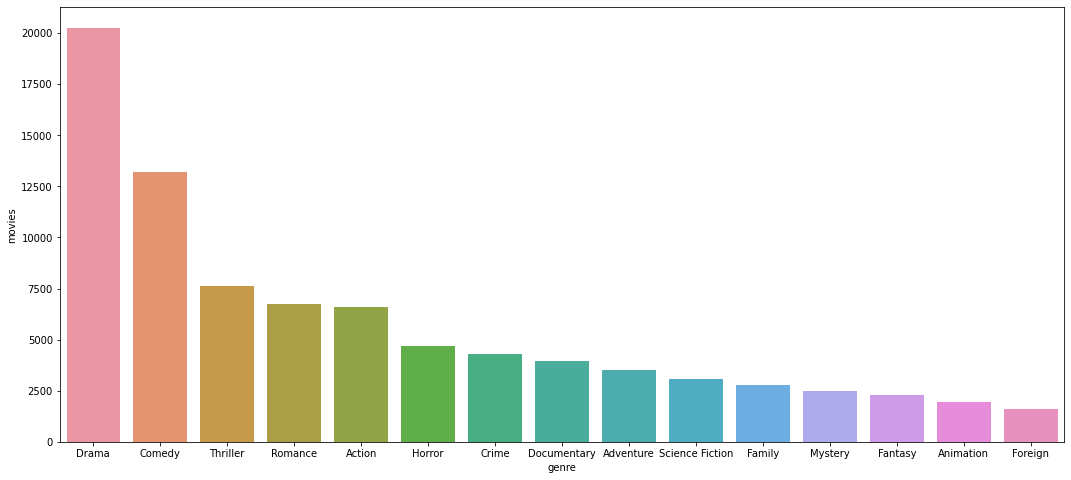

In [22]:
plt.figure(figsize=(18,8))
sns.barplot(x='genre', y='movies', data=pop_gen.head(15))
plt.show()

#### IMDB's *weighted rating* formula 

Mathematically, it is represented as follows:

Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$

where,
* *v* is the number of votes for the movie
* *m* is the minimum votes required to be listed in the chart
* *R* is the average rating of the movie
* *C* is the mean vote across the whole report

Now, determine an cutoff value for *m*, the minimum votes required to be listed in the chart. 

in this model used cutoff is **95th percentile** that means for a movie to feature in the top N must have more votes than at least 95% of the movies in the list.

#### Calculate C

In [23]:
# Calculation of c 
vote_counts = m_df[m_df['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = m_df[m_df['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

#### Calculate m 

In [24]:
## Calculation of m
m = vote_counts.quantile(0.95)
m

434.0

In [25]:
# extracting release year from release_date
m_df['year'] = pd.to_datetime(m_df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] 
                                                                           if x != np.nan else np.nan)

#### Getting qualified movies (cutoff: 95%)

In [26]:
col_list = ['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']
qualified = m_df[(m_df['vote_count'] >= m) 
                 & (m_df['vote_count'].notnull()) 
                 & (m_df['vote_average'].notnull())][col_list]

# converting vote_count and vote_average colums to integer
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

Findings as follow:
1. for consideration in the chart, a movie has to have at least **434 votes**. 
2. the average rating for a movie is **5.244** on a scale of 10. 
3. **2274** Movies qualify to be on the chart.

### Calculating weighted ratings and making top 250 chart

In [ ]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
qualified['weighted_rating'] = qualified.apply(weighted_rating, axis=1)

In [ ]:
qualified = qualified.sort_values('weighted_rating', ascending=False).head(250)

### Top 10 Movies

In [ ]:
qualified.head(10)

,title,year,vote_count,vote_average,popularity,genres,weighted_rating
15480,Inception,2010,14075,8,29.1081,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.2135,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.8696,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.0707,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.95,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.6454,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.3244,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.3072,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.4235,"[Adventure, Fantasy, Action]",7.851924


5 out 10 movies of genres drama. Also three Christopher Nolan Films, **Inception**, **The Dark Knight** and **Interstellar** are part of top 10 list. The list coins a strong bias towards meta data like genres, directors etc. 

Now, building list for particular genres. For that, cutoff is relaxed to **85%** instead of 95. 

In [ ]:
temp = m_df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
temp.name = 'genre'
mgen_df = m_df.drop('genres', axis=1).join(temp)

In [ ]:
def make_toplist(genre, percentile=0.85):
    df = mgen_df[mgen_df['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    col_list = ['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genre']
    qualified = df[(df['vote_count'] >= m) 
                   & (df['vote_count'].notnull()) 
                   & (df['vote_average'].notnull())][col_list]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['weighted_rating'] = qualified.apply(lambda x: 
                                                   (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), 
                                                   axis=1)
    qualified = qualified.sort_values('weighted_rating', ascending=False).head(250)
    
    return qualified

### Top 10 Thriller Movies

In [ ]:
make_toplist('Thriller').head(10)

,title,year,vote_count,vote_average,popularity,genre,weighted_rating
15480,Inception,2010,14075,8,29.1081,Thriller,7.956460
12481,The Dark Knight,2008,12269,8,123.167,Thriller,7.950165
292,Pulp Fiction,1994,8670,8,140.95,Thriller,7.929996
46,Se7en,1995,5915,8,18.4574,Thriller,7.898573
24860,The Imitation Game,2014,5895,8,31.5959,Thriller,7.898242
586,The Silence of the Lambs,1991,4549,8,4.30722,Thriller,7.869538
11354,The Prestige,2006,4510,8,16.9456,Thriller,7.868463
289,Leon: The Professional,1994,4293,8,20.4773,Thriller,7.862142
4099,Memento,2000,4168,8,15.4508,Thriller,7.858217
1213,The Shining,1980,3890,8,19.6116,Thriller,7.848633


## Content Based Recommendation model

** Limitation of Popularity model ** <br>
It gives the same recommendation to everyone, regardless of the user's personal interest. <br>

_For example:_ If a person who loves romantic movies were to look at Top 15 romantic movies, and he wouldn't probably like most of the listed movies. So, he were to go one step further and look at movie lists by genre, he wouldn't still be getting the interesting recommendations. Let say, he loves *Dilwale Dulhania Le Jayenge*, *My Name is Khan* and *Kabhi Khushi Kabhi Gham*. We can probable assume that he loves the actor Shahrukh Khan and the director Karan Johar. Even if he were to access the top romance list, he wouldn't find these in the list.

Therefore, let's build a model that computes similarity between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user liked. For that we have to consider metadata (or content), hence, it also known as **Content Based Filtering.**

Two Content Based Recommendation is implemented based on different contents:
1. Description Based (content: Movie Overviews and Taglines)
2. Meta Data Based (content : Movie Cast, Crew, Keywords and Genre)

** Note **: A small movie data set is used due to limiting computing power available to me. 

In [ ]:
small_mdf = pd.read_csv('/content/drive/MyDrive/data (1)/links_small.csv')


In [ ]:
small_mdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9125 non-null   int64  
 1   imdbId   9125 non-null   int64  
 2   tmdbId   9112 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 214.0 KB


In [ ]:
small_mdf = small_mdf[small_mdf['tmdbId'].notnull()]['tmdbId'].astype('int')

Before extracting small data set, we need to make sure that the ID column of our main dataframe is clean and of type integer. To do this, let us try to perform an integer conversion of our IDs and if an exception is raised,we will replace the ID with NaN. We will then proceed to drop these rows from our dataframe.

In [ ]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [ ]:
m_df['id'] = m_df['id'].apply(convert_int)

In [ ]:
m_df[m_df['id'].isnull()]

,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
19730,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[Carousel Productions, Vision View Entertainme...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",NaN,0,104.0,Released,NaN,<img src='http://image.tmdb.org/t/p/w185/Midni...,False,6.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
29503,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[Aniplex, GoHands, BROSTA TV, Mardock Scramble...","[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,0,68.0,Released,NaN,<img src='http://image.tmdb.org/t/p/w185/Mardo...,False,7.0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
35587,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[Odyssey Media, Pulser Productions, Rogue Stat...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",NaN,0,82.0,Released,Beware Of Frost Bites,<img src='http://image.tmdb.org/t/p/w185/Avala...,False,4.3,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [ ]:
m_df = m_df.drop([19730, 29503, 35587])
m_df['id'] = m_df['id'].astype('int')

In [ ]:
sm_df = m_df[m_df['id'].isin(small_mdf)]
sm_df.shape

(9099, 23)

**9099** movies avaiable in our small movies metadata dataset 

### 1. Description Based Recommendation

In [ ]:
sm_df['tagline'] = sm_df['tagline'].fillna('')
sm_df['description'] = sm_df['overview'] + sm_df['tagline']
sm_df['description'] = sm_df['description'].fillna('')

#### Compute TF-IDF matrix 

In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(sm_df['description'])
tfidf_matrix.shape

(9099, 268124)

#### Cosine Similarity

The Cosine Similarity is used to calculate a numeric quantity that denotes the similarity between two movies. Mathematically, it is defined as follows:

$cosine(x,y) = \frac{x. y^\intercal}{||x||.||y||} $

Since the TF-IDF Vectorizer is used, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, sklearn's **linear_kernel** is used instead of cosine_similarities as it's much faster.

In [ ]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

We now have a pairwise cosine similarity matrix for all the movies in our dataset. The next step is to write a function that returns the 50 most similar movies based on the cosine similarity score.

In [ ]:
sm_df = sm_df.reset_index()
titles = sm_df['title']
indices = pd.Series(sm_df.index, index=sm_df['title'])

In [ ]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:51]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

Let us now try and get the top 10 recommendations for a few movies.

In [ ]:
get_recommendations('The Godfather').head(10)

973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
Name: title, dtype: object

In [ ]:
get_recommendations('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

We see that for **The Dark Knight**, our system is able to identify it as a Batman film and subsequently recommend other Batman films as its top recommendations. But unfortunately, that is all this system can do at the moment. This is not of much use to most people as it doesn't take into considerations very important features such as cast, crew, director and genre, which determine the rating and the popularity of a movie. Someone who liked **The Dark Knight** probably likes it more because of Nolan and would hate **Batman Forever** and every other substandard movie in the Batman Franchise.

Therefore, we are going to use much more suggestive metadata than **Overview** and **Tagline**. In the next subsection, Let's build a more sophisticated recommender that takes **genre**, **keywords**, **cast** and **crew** into consideration.

### 2.  Metadata Based Recommendation

In [ ]:
credits = pd.read_csv('/content/drive/MyDrive/data (1)/credits.csv')
keywords = pd.read_csv('/content/drive/MyDrive/data (1)/keywords.csv')

In [ ]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [ ]:
keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


In [ ]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
m_df['id'] = m_df['id'].astype('int')
m_df.shape

(45463, 23)

In [ ]:
# merging require details with our main dataframe 
m_df = m_df.merge(credits, on='id')
m_df = m_df.merge(keywords, on='id')

In [ ]:
sm_df = m_df[m_df['id'].isin(small_mdf)]
sm_df.shape

(9219, 26)

We now have our cast, crew, genres and credits, all in one dataframe. Let us wrangle this a little more using the following intuitions:

1. **Crew:** From the crew, we will only pick the director as our feature since the others don't contribute that much to the *feel* of the movie.
2. **Cast:** Choosing Cast is a little more tricky. Lesser known actors and minor roles do not really affect people's opinion of a movie. Therefore, we must only select the major characters and their respective actors. Arbitrarily we will choose the top 3 actors that appear in the credits list. 

In [ ]:
sm_df['cast'] = sm_df['cast'].apply(literal_eval)
sm_df['crew'] = sm_df['crew'].apply(literal_eval)
sm_df['keywords'] = sm_df['keywords'].apply(literal_eval)
sm_df['cast_size'] = sm_df['cast'].apply(lambda x: len(x))
sm_df['crew_size'] = sm_df['crew'].apply(lambda x: len(x))

In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
sm_df['director'] = sm_df['crew'].apply(get_director)

In [ ]:
sm_df['cast'] = sm_df['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
sm_df['cast'] = sm_df['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [ ]:
sm_df['keywords'] = sm_df['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

The approach to building the recommendation is going to be extremely *hacky*. The plan on doing is creating a metadata dump for every movie which consists of **genres, director, main actors and keywords.** I then use a **Count Vectorizer** to create our count matrix as we did in the Description Recommender. The remaining steps are similar to what we did earlier: we calculate the cosine similarities and return movies that are most similar.

These are steps I follow in the preparation of genres and credits data:
1. **Strip Spaces and Convert to Lowercase** from all our features. This way, engine will not confuse between **Johnny Depp** and **Johnny Galecki.** 
2. **Mention Director 2 times** to give it more weight relative to the entire cast.

In [ ]:
sm_df['cast'] = sm_df['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
sm_df['director'] = sm_df['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
sm_df['director'] = sm_df['director'].apply(lambda x: [x,x])

#### Keywords

We will do a small amount of pre-processing of our keywords before putting them to any use. As a first step, we calculate the frequenct counts of every keyword that appears in the dataset.

In [ ]:
s = sm_df.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [ ]:
s = s.value_counts()
s[:5]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: keyword, dtype: int64

Keywords occur in frequencies ranging from 1 to 610. We do not have any use for keywords that occur only once. Therefore, these can be safely removed. Finally, we will convert every word to its stem so that words such as *Dogs* and *Dog* are considered the same.

In [ ]:
s = s[s > 1]

In [ ]:
stemmer = SnowballStemmer('english')
stemmer.stem('eating')

'eat'

In [ ]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [ ]:
sm_df['keywords'] = sm_df['keywords'].apply(filter_keywords)
sm_df['keywords'] = sm_df['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
sm_df['keywords'] = sm_df['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
sm_df['soup'] = sm_df['keywords'] + sm_df['cast'] + sm_df['director'] + sm_df['genres']
sm_df['soup'] = sm_df['soup'].apply(lambda x: ' '.join(x))

In [ ]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(sm_df['soup'])

In [ ]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
sm_df = sm_df.reset_index()
titles = sm_df['title']
indices = pd.Series(sm_df.index, index=sm_df['title'])

We will reuse the get_recommendations function that we had written earlier. Since our cosine similarity scores have changed, we expect it to give us different (and probably better) results. Let us check for **The Dark Knight** again and see what recommendations I get this time around.

In [ ]:
get_recommendations('The Dark Knight').head(10)

8031                 The Dark Knight Rises
6218                         Batman Begins
7659            Batman: Under the Red Hood
6623                          The Prestige
1134                        Batman Returns
8927               Kidnapping Mr. Heineken
5943                              Thursday
1260                        Batman & Robin
2085                             Following
9024    Batman v Superman: Dawn of Justice
Name: title, dtype: object

The recommendations seem to have recognized other Christopher Nolan movies (due to the high weightage given to director) and put them as top recommendations. Person enjoyed watching **The Dark Knight** as well as some of the other ones in the list including **Batman Begins**, **The Prestige** and **The Dark Knight Rises**. 

We can of course experiment on this engine by trying out different weights for our features (directors, actors, genres), limiting the number of keywords that can be used in the soup, weighing genres based on their frequency, only showing movies with the same languages, etc.

In [ ]:
get_recommendations('Pulp Fiction').head(10)

1381         Jackie Brown
8905    The Hateful Eight
5200    Kill Bill: Vol. 2
4595                Basic
4764             S.W.A.T.
898        Reservoir Dogs
6939              Cleaner
4903    Kill Bill: Vol. 1
231         Kiss of Death
4306       The 51st State
Name: title, dtype: object

#### Popularity and Ratings

One thing that we notice about our recommendation system is that it recommends movies regardless of ratings and popularity. It is true that **Batman and Robin** has a lot of similar characters as compared to **The Dark Knight** but it was a terrible movie that shouldn't be recommended to anyone.

Therefore, we will add a mechanism to remove bad movies and return movies which are popular and have had a good critical response.

I will take the top 50 movies based on similarity scores and calculate the vote of the 60th percentile movie. Then, using this as the value of $m$, we will calculate the weighted rating of each movie using IMDB's formula like we did in the Simple Recommender section.

In [ ]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:51]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = sm_df.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year','genres']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [ ]:
improved_recommendations('The Dark Knight')

,title,vote_count,vote_average,year,genres,wr
7648,Inception,14075,8,2010,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
6623,The Prestige,4510,8,2006,"[Drama, Mystery, Thriller]",7.758148
8031,The Dark Knight Rises,9263,7,2012,"[Action, Crime, Drama, Thriller]",6.921448
6218,Batman Begins,7511,7,2005,"[Action, Crime, Drama]",6.904127
524,Batman,2145,7,1989,"[Fantasy, Action]",6.704647
1031,M,465,8,1931,"[Drama, Action, Thriller, Crime]",6.669950
7659,Batman: Under the Red Hood,459,7,2010,"[Action, Animation]",6.147016
2085,Following,363,7,1998,"[Crime, Drama, Thriller]",6.044272
1134,Batman Returns,1706,6,1992,"[Action, Fantasy]",5.846862
4145,Insomnia,1181,6,2002,"[Crime, Mystery, Thriller]",5.797081


In [ ]:
improved_recommendations('Pulp Fiction')

,title,vote_count,vote_average,year,genres,wr
898,Reservoir Dogs,3821,8,1992,"[Crime, Thriller]",7.718986
7280,Inglourious Basterds,6598,7,2009,"[Drama, Action, Thriller, War]",6.891679
4903,Kill Bill: Vol. 1,5091,7,2003,"[Action, Crime]",6.862133
8905,The Hateful Eight,4405,7,2015,"[Crime, Drama, Mystery, Western]",6.842588
5200,Kill Bill: Vol. 2,4061,7,2004,"[Action, Crime, Thriller]",6.830542
1381,Jackie Brown,1580,7,1997,"[Comedy, Crime, Romance]",6.621790
4185,Road to Perdition,1102,7,2002,"[Thriller, Crime, Drama]",6.504092
8110,The Raid,1076,7,2011,"[Action, Thriller, Crime]",6.495553
8408,Fast & Furious 6,5282,6,2013,"[Action, Thriller, Crime]",5.942667
8390,Pain & Gain,1595,6,2013,"[Thriller, Crime, Action]",5.838485


## Collaborative Filtering



** Limitation of content based recommendation**: 
- It is only capable of suggesting movies which are *close* to a certain movie. That is, it is not capable of capturing interest and providing recommendations across genres.

- It doesn't capture the personal intrest and biases of a user. Anyone querying on model for recommendations based on a movie will receive the same recommendations for that movie, regardless of who he is.

Therefore, in this section, we will use a technique called **Collaborative Filtering** to make recommendations to Movie Watchers. Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

We will use the **Surprise** library that used extremely powerful algorithms like **Singular Value Decomposition (SVD)** to minimise RMSE (Root Mean Square Error) and give great recommendations.

In [ ]:
reader = Reader()

In [ ]:
ratings = pd.read_csv('/content/drive/MyDrive/data (1)/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [ ]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5)

{'fit_time': (5.0245702266693115,
  4.977882623672485,
  5.0020341873168945,
  4.937376499176025,
  4.978933811187744),
 'test_mae': array([0.70017926, 0.68340325, 0.6925405 , 0.6868742 , 0.68817562]),
 'test_rmse': array([0.90864866, 0.88691322, 0.89885277, 0.89535376, 0.89343426]),
 'test_time': (0.3599412441253662,
  0.1714766025543213,
  0.16443228721618652,
  0.3620569705963135,
  0.16534042358398438)}

We get a mean **Root Mean Sqaure Error** of 0.8965 which is more than good enough right now. Let us now train on dataset and arrive at predictions.

In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

Let us pick user 5000 and check the ratings he has given.

In [ ]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [ ]:
svd.predict(1, 3671, 3)

Prediction(uid=1, iid=3671, r_ui=3, est=2.925153710089088, details={'was_impossible': False})

For movie with ID 3671, we get an estimated prediction of **2.925**. 

we build a simple hybrid recommender that brings together techniques we have implemented in the content based and collaborative filter based engines. This is how it will work:

* **Input:** User ID and the Title of a Movie
* **Output:** Similar movies sorted on the basis of expected ratings by that particular user.

**Hybrid Recommender**

In [ ]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [ ]:
id_map = pd.read_csv('/content/drive/MyDrive/data (1)/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(sm_df[['title', 'id']], on='id').set_index('title')
#id_map = id_map.set_index('tmdbId')

In [ ]:
indices_map = id_map.set_index('id')

In [ ]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = sm_df.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id','genres']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [ ]:
hybrid(1, 'The Dark Knight')

,title,vote_count,vote_average,year,id,genres,est
6623,The Prestige,4510.0,8.0,2006,1124,"[Drama, Mystery, Thriller]",3.200922
7362,Gangster's Paradise: Jerusalema,16.0,6.8,2008,22600,"[Drama, Action, Crime, Foreign]",3.024756
3647,An Innocent Man,28.0,6.4,1989,29185,"[Action, Crime, Drama, Thriller]",2.962927
7561,Harry Brown,351.0,6.7,2009,25941,"[Thriller, Crime, Drama, Action]",2.937894
5943,Thursday,84.0,7.0,1998,9812,"[Drama, Action, Crime, Thriller]",2.873410
8031,The Dark Knight Rises,9263.0,7.6,2012,49026,"[Action, Crime, Drama, Thriller]",2.862875
5098,The Enforcer,21.0,7.4,1951,26712,"[Drama, Action, Crime]",2.844136
628,Force of Evil,33.0,6.6,1948,26744,"[Drama, Action, Crime]",2.840670
217,The Glass Shield,9.0,5.4,1994,72031,"[Drama, Action, Thriller, Crime]",2.791552
4021,The Long Good Friday,87.0,7.1,1980,14807,"[Crime, Drama, Action, Thriller]",2.745109


In [ ]:
hybrid(346, 'The Dark Knight')

,title,vote_count,vote_average,year,id,genres,est
217,The Glass Shield,9.0,5.4,1994,72031,"[Drama, Action, Thriller, Crime]",4.173982
7362,Gangster's Paradise: Jerusalema,16.0,6.8,2008,22600,"[Drama, Action, Crime, Foreign]",4.045278
8031,The Dark Knight Rises,9263.0,7.6,2012,49026,"[Action, Crime, Drama, Thriller]",3.942208
7561,Harry Brown,351.0,6.7,2009,25941,"[Thriller, Crime, Drama, Action]",3.750806
7582,Defendor,197.0,6.5,2009,34769,"[Drama, Action, Comedy, Crime]",3.680019
6623,The Prestige,4510.0,8.0,2006,1124,"[Drama, Mystery, Thriller]",3.665734
5098,The Enforcer,21.0,7.4,1951,26712,"[Drama, Action, Crime]",3.615776
5943,Thursday,84.0,7.0,1998,9812,"[Drama, Action, Crime, Thriller]",3.577278
2085,Following,363.0,7.2,1998,11660,"[Crime, Drama, Thriller]",3.555525
5809,Point Blank,97.0,7.1,1967,26039,"[Action, Crime, Drama, Thriller]",3.502032


We see that for our hybrid recommender, we get different recommendations for different users although the movie is the same. Hence, our recommendations are more personalized and tailored towards particular users.